## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera Calibration using Chessboard

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# visualization will be shown in the notebook
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images[1:2]:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # cv2.imshow('img',img)
        # cv2.waitKey(500)

cv2.destroyAllWindows()

## Define Methods to Undistort Images

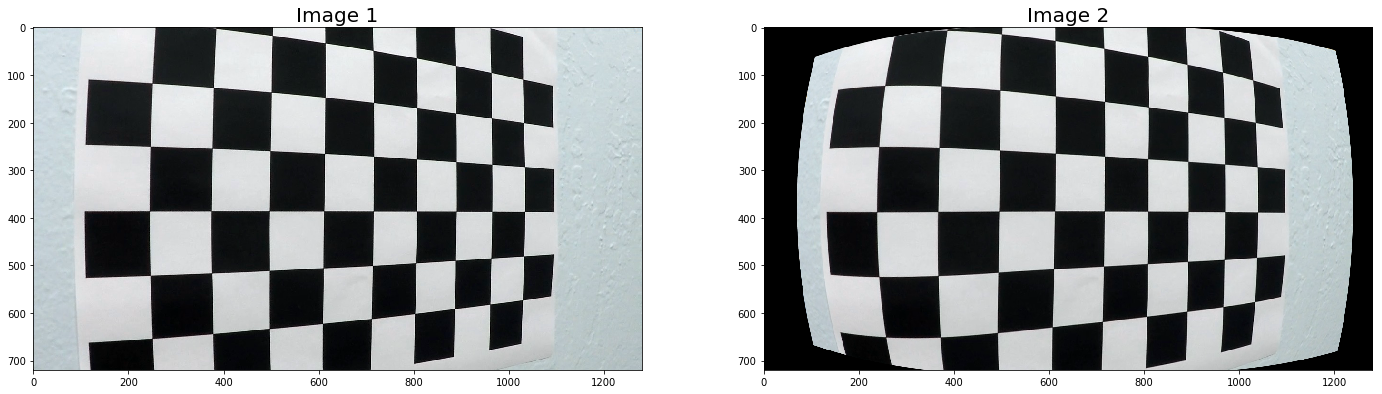

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    # Do camera calibration given object points and image points
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def plot_image_comparison(image1, image2, is_gray=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    if is_gray:
        ax1.imshow(image1, cmap='gray')
        ax2.imshow(image2, cmap='gray')
    else:
        ax1.imshow(image1)
        ax2.imshow(image2)
    ax1.set_title('Image 1', fontsize=20)
    ax2.set_title('Image 2', fontsize=20)

# show an example of the undistorted image
img = cv2.imread('camera_cal/calibration5.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
plot_image_comparison(img, undistorted)

## Define a pipeline to binarize an image

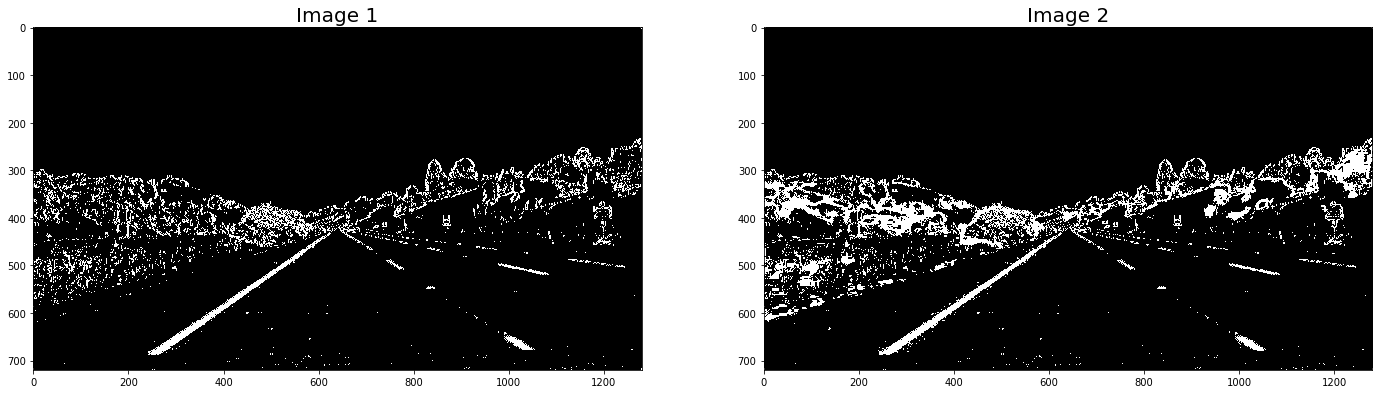

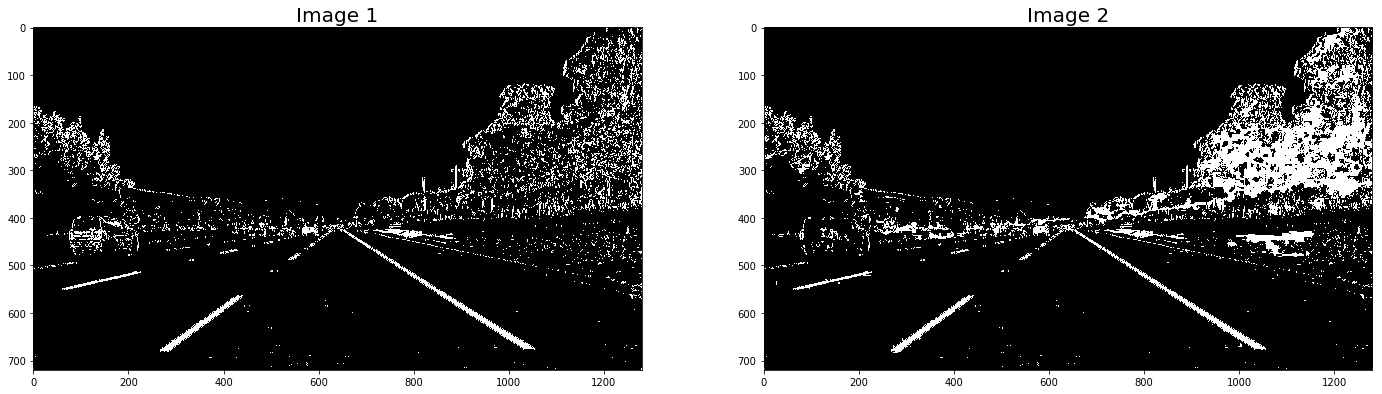

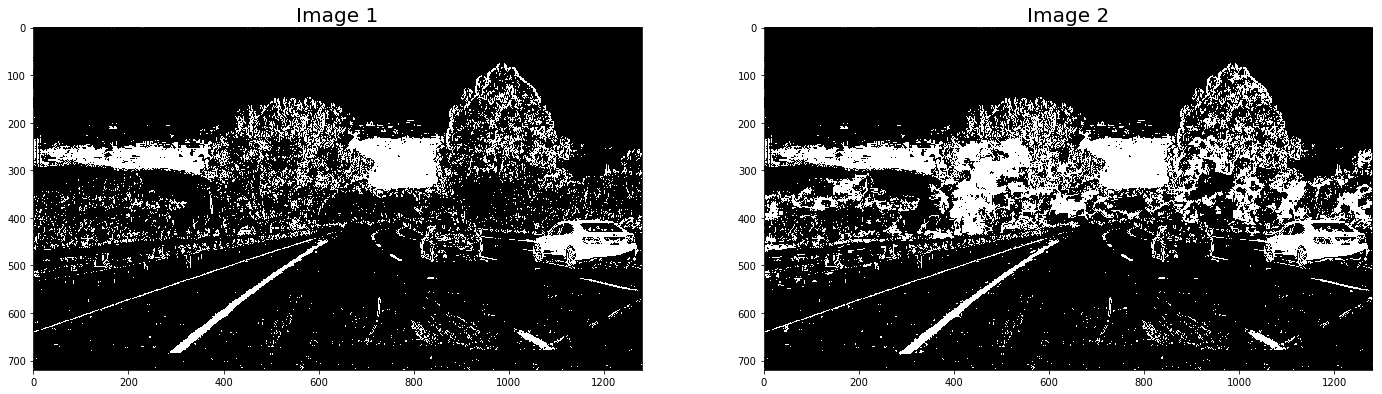

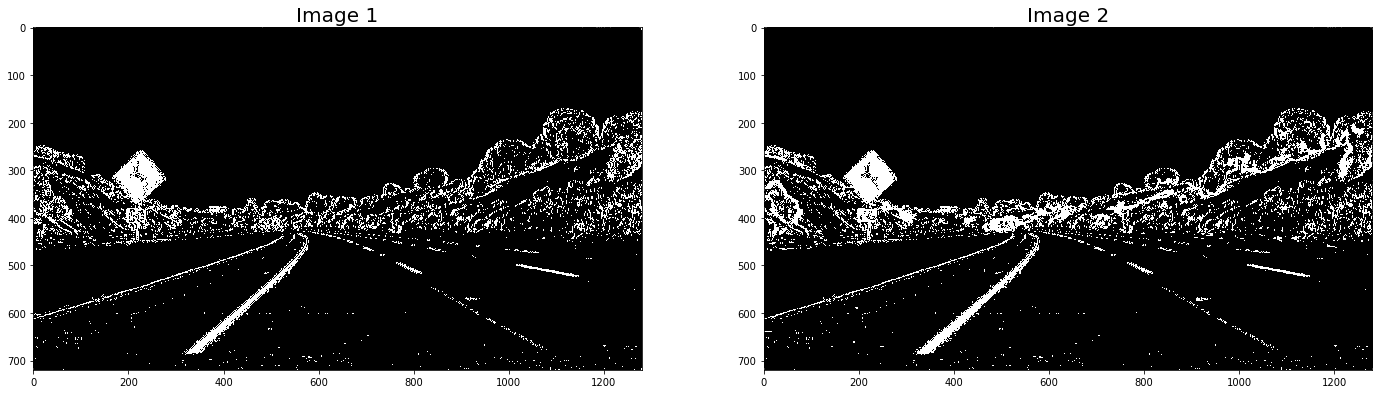

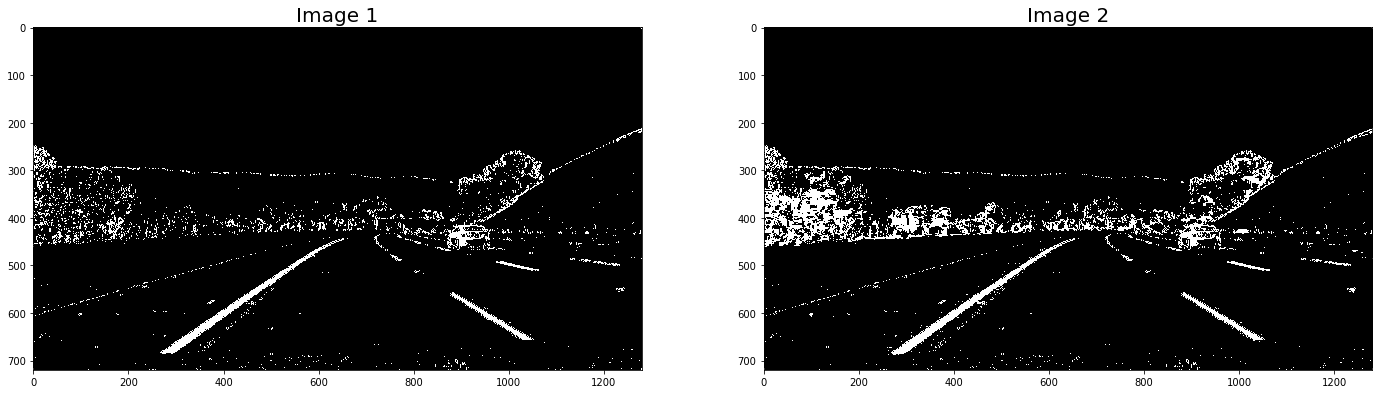

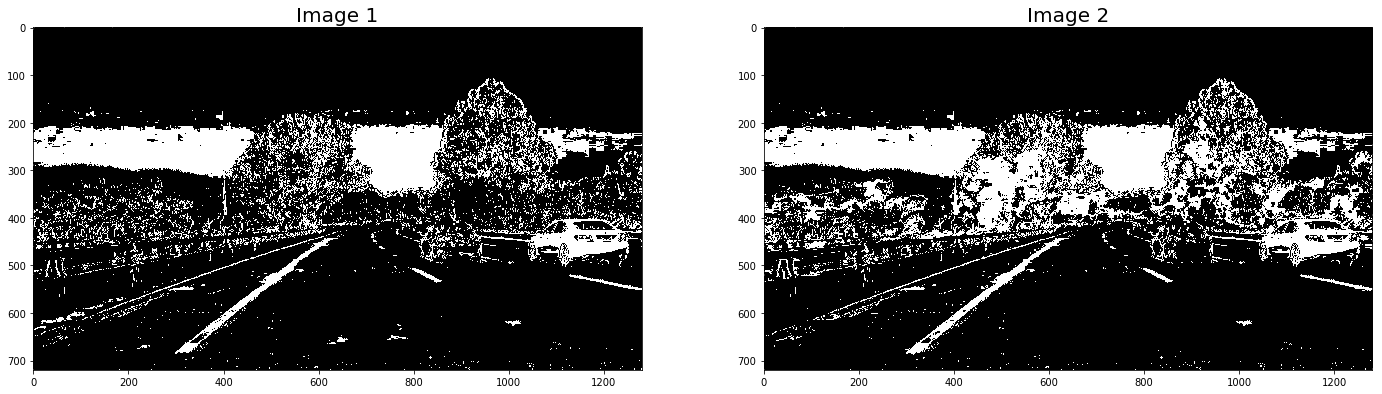

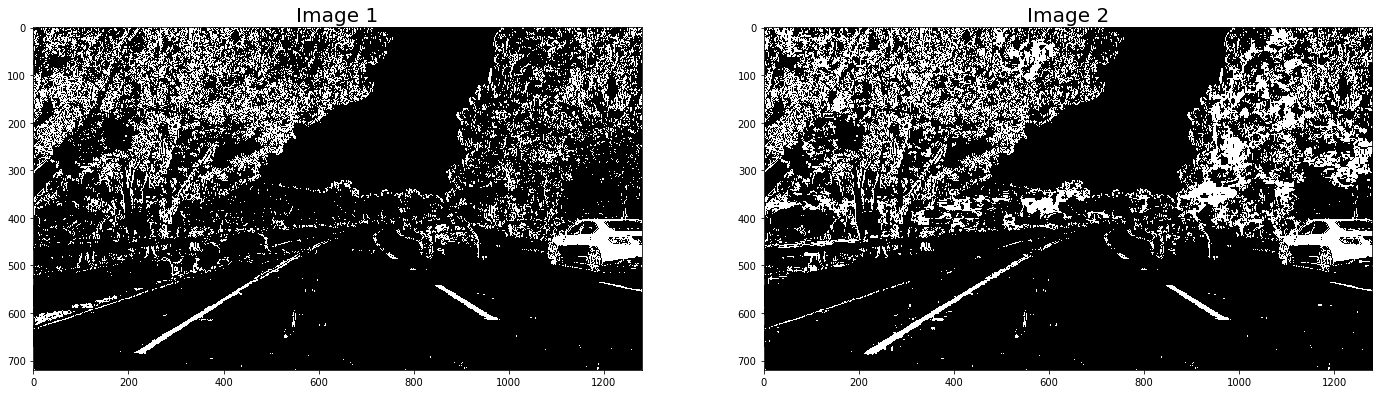

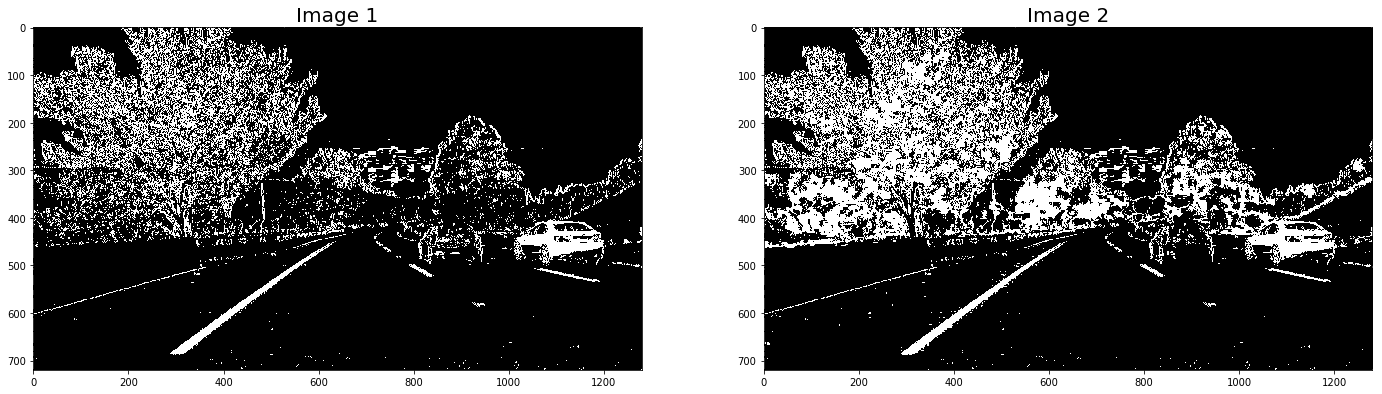

In [3]:
import matplotlib.image as mpimg

def reduce_image(img, sx_thresh=(20, 100), s_thresh=(200, 250), h_thresh=(20, 25), v_thresh=(220, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # H-channel between 20-25 is for yellow hue
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    # v-channel high for bright and highly reflective materials
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    # color_binary = np.dstack((s_binary, v_binary, sxbinary)) * 255
    
    # Combined binary1 (probably most robust, due to having saturation channel)
    combined_binary1 = np.zeros_like(sxbinary)
    combined_binary1[(s_binary == 1) | (v_binary == 1) | (sxbinary == 1)] = 1
    
    # Combined binary2 (probably the most clear in this example)
    combined_binary2 = np.zeros_like(sxbinary)
    combined_binary2[(h_binary == 1) | (v_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary1.astype(np.uint8), combined_binary2.astype(np.uint8)

# test the pipeline and see if it actually works
test_images = glob.glob('test_images/*.jpg')
#test_images = ['test_images/straight_lines1.jpg']
for image in test_images:
    img = mpimg.imread(image)
    result1, result2 = reduce_image(img)
    plot_image_comparison(result1, result2, True)

## Define a function to do a perspective transform

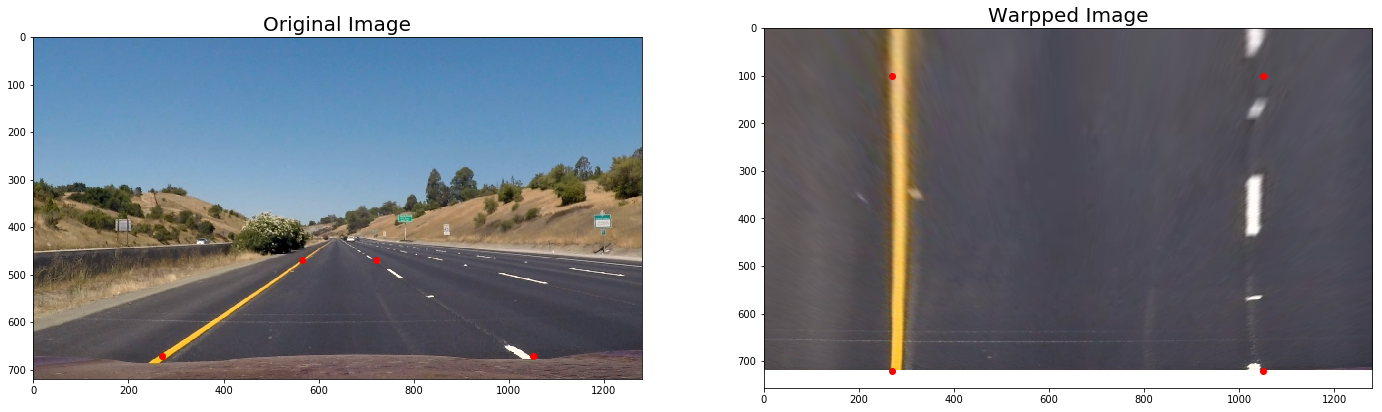

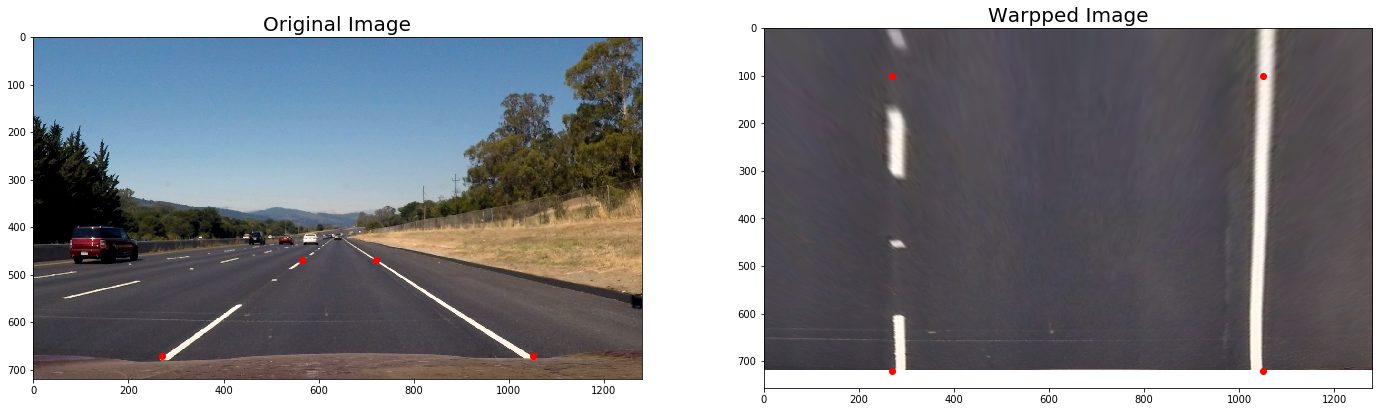

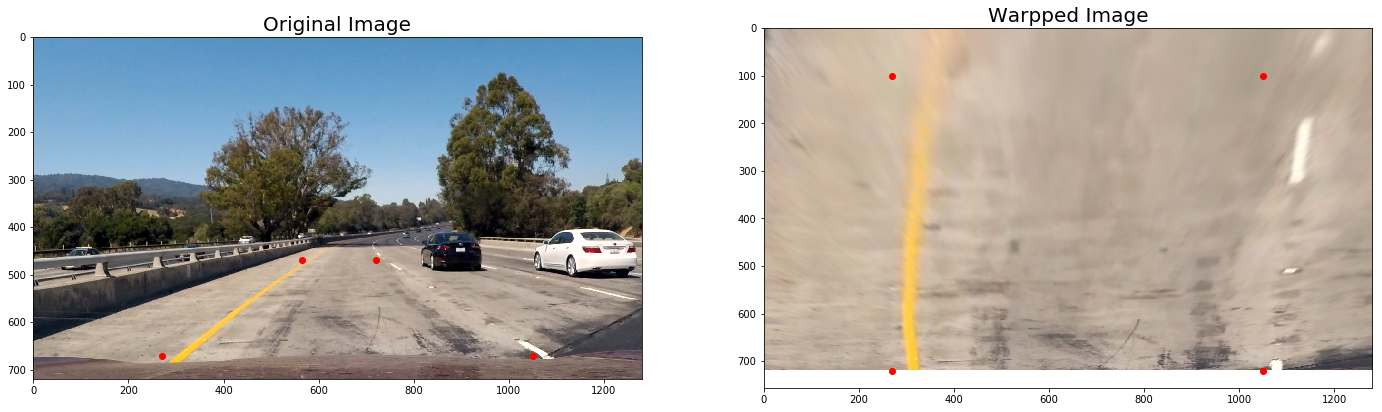

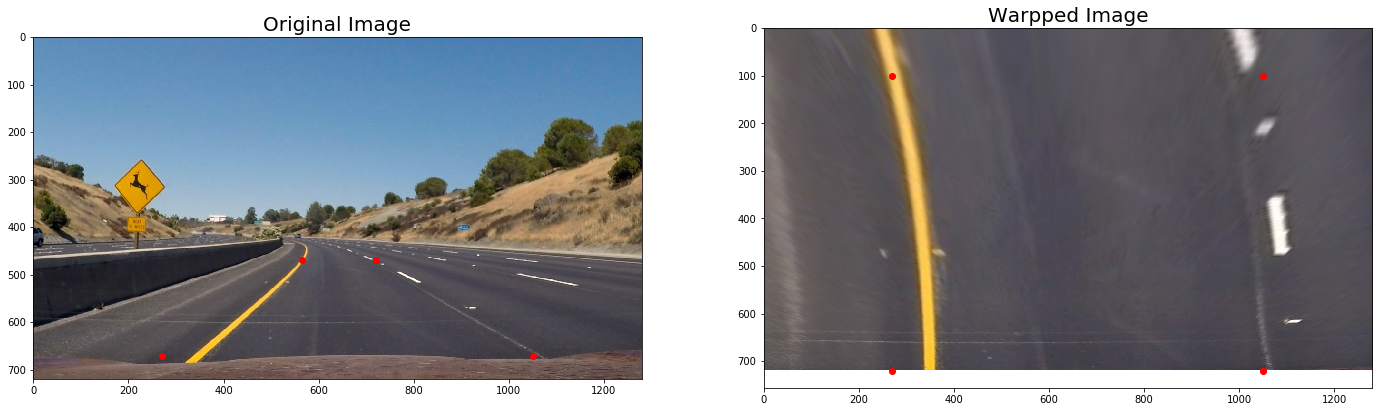

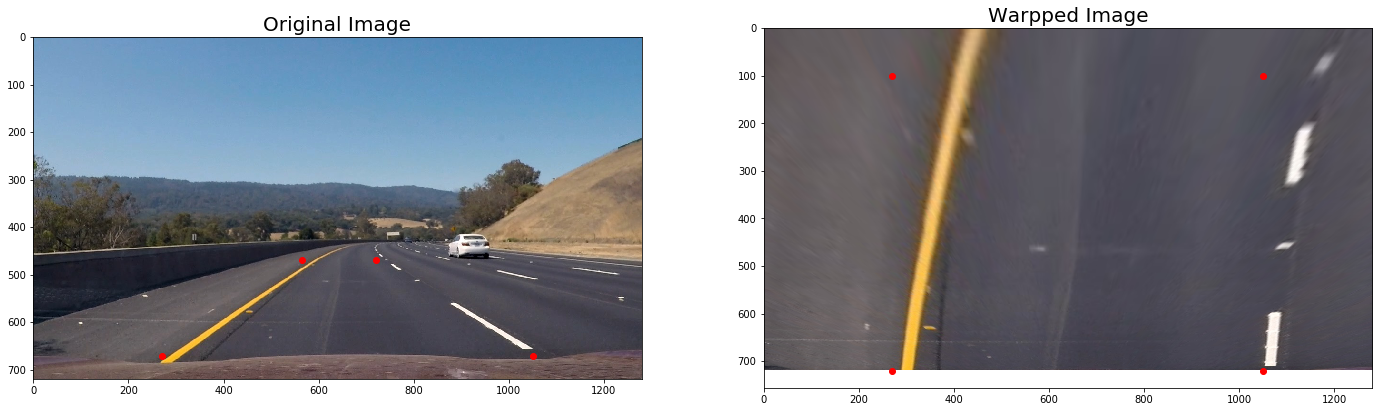

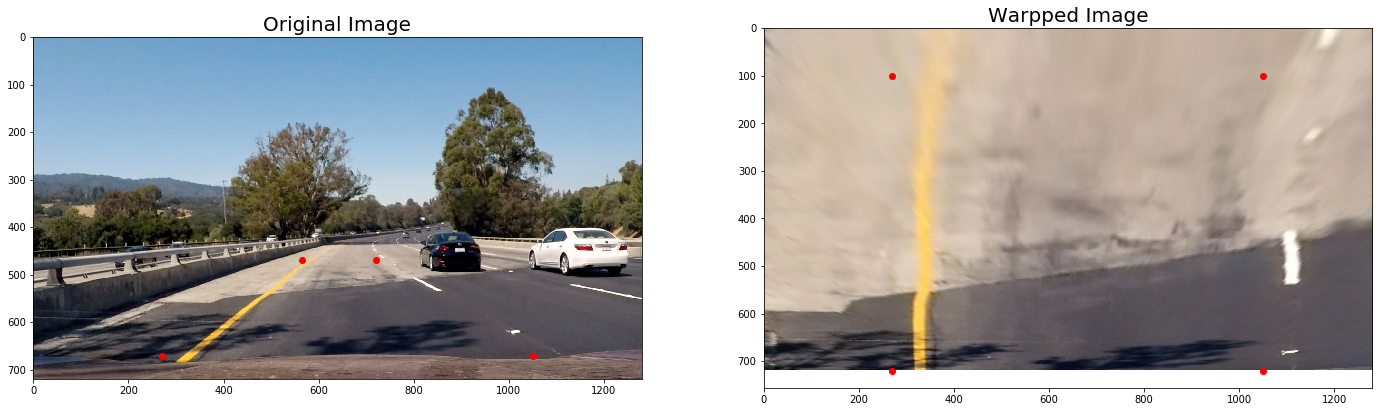

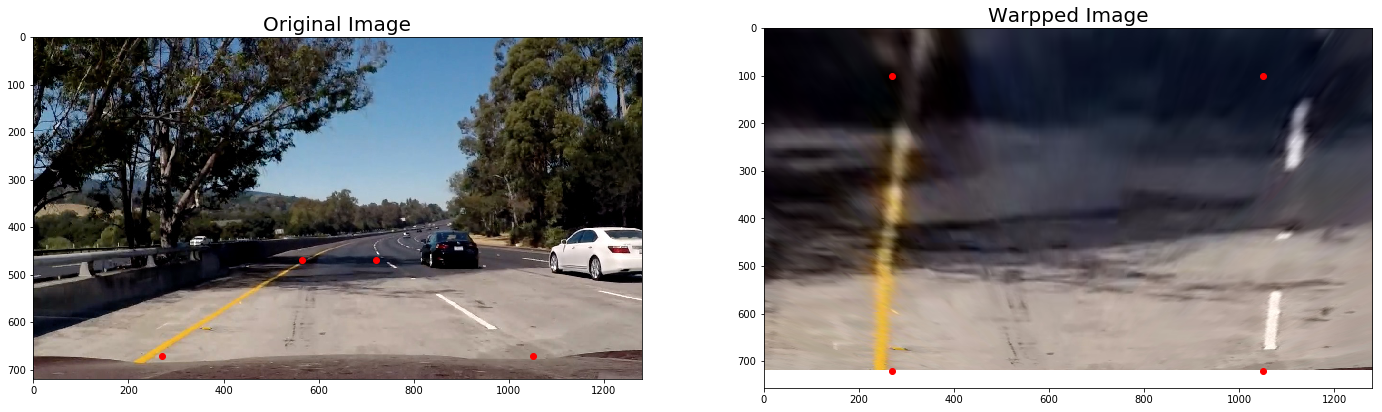

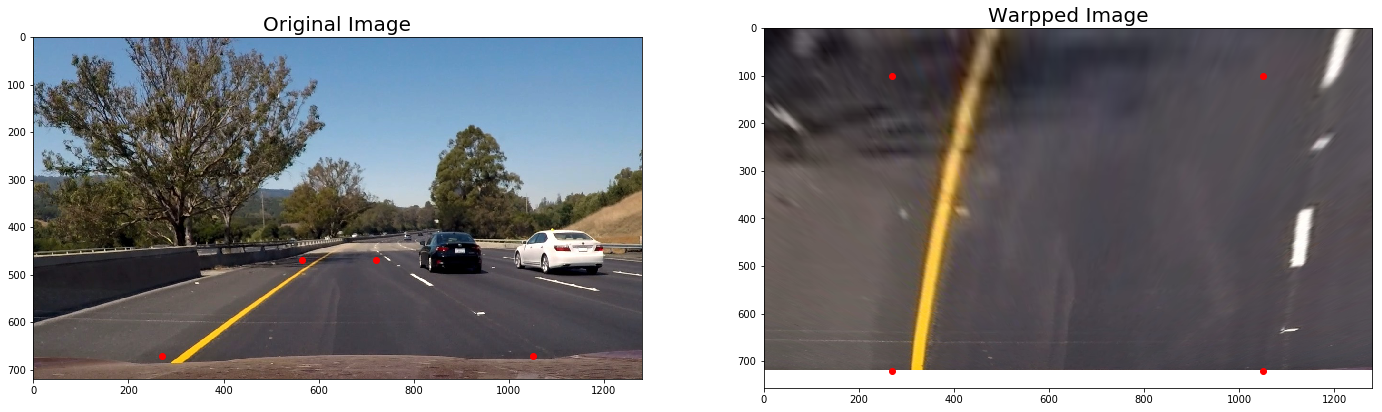

In [4]:
def plot_points_to_fig(fig, points):
    for coords, prop in zip(points.tolist(), np.repeat('ro', 4)):
        fig.plot(*coords, prop)

def perspective_transform(img, plot=False):
    img_size = (img.shape[1], img.shape[0])

    # below are the src and dst calibrated by hand
    # setting plot=True can help visualize the points on the fig to help calibration process
    src = np.float32([(565, 470), (720, 470), (1050, 670), (270, 670)])
    dst = np.float32([(270, 100), (1050, 100), (1050, 720), (270, 720)])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    if plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))

        # plot the original image
        ax1.imshow(img)
        plot_points_to_fig(ax1, src)
        ax1.set_title('Original Image', fontsize=20)

        # plot the warpped image
        ax2.imshow(warped)
        plot_points_to_fig(ax2, dst)
        ax2.set_title('Warpped Image', fontsize=20)

    return warped, M, Minv

test_images = glob.glob('test_images/*.jpg')
#test_images = ['test_images/straight_lines1.jpg']
for image in test_images:
    img = mpimg.imread(image)
    perspective_transform(img, True)

## Define a pipeline to get a top down view of the lane

In [5]:
def get_top_down(img):
    undistorted_img = cal_undistort(img, objpoints, imgpoints)
    reduced_img, _ = reduce_image(undistorted_img)
    top_down, _, Minv = perspective_transform(reduced_img)

    return top_down, Minv


## Define a function polynomial fit of the lane lines

In [6]:
def get_lane_line_fits_default(binary_warped, plot=False, margin=100, minpix=50):
    """
    :param binary_warped: a top-down view of the lane line image
    :param plot: whether to plot the fitted lines onto the input image, for debugging purpose
    :param margin: the width of the windows +/- margin
    :param minpix: minimum number of pixels found to recenter window
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # check if there are more pixels identified in the left than the right, 
        # use this information to inform the sliding window move
        left_dominant = len(good_left_inds) > len(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if left_dominant and len(good_left_inds) > minpix:
            new_leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            rightx_current = rightx_current + (new_leftx_current - leftx_current)
            leftx_current = new_leftx_current
        if not left_dominant and len(good_right_inds) > minpix: 
            new_rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            leftx_current = leftx_current + (new_rightx_current - rightx_current)        
            rightx_current = new_rightx_current
            

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if plot:       
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        
        ax1.imshow(binary_warped)
        ax2.imshow(out_img)
        ax2.plot(left_fitx, ploty, color='yellow')
        ax2.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit


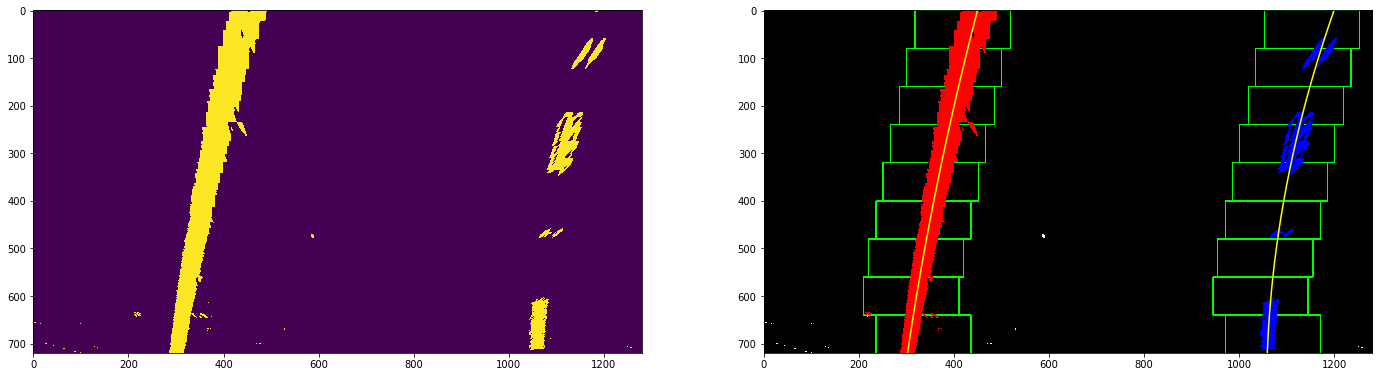

In [7]:
img = mpimg.imread('test_images/test3.jpg')
top_down, _ = get_top_down(img)
out = get_lane_line_fits_default(top_down, True)


## Define a function that can optionally use previous fit data to find lane lines

In [8]:

def get_lane_line_fits(binary_warped, plot=False, fits=None, margin=100, minpix=50):
    """
    :param binary_warped: a top-down view of the lane line image
    :param plot: whether to plot the fitted lines onto the input image, for debugging purpose
    :param margin: the width of the windows +/- margin
    :param minpix: minimum number of pixels found to recenter window
    """
    if fits is None:
        return get_lane_line_fits_default(binary_warped, plot, margin, minpix)

    # unpack the fit parameters
    left_fit, right_fit = fits

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if plot:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        window_img = np.zeros_like(out_img)
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure(figsize=(24,9))
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    return left_fit, right_fit

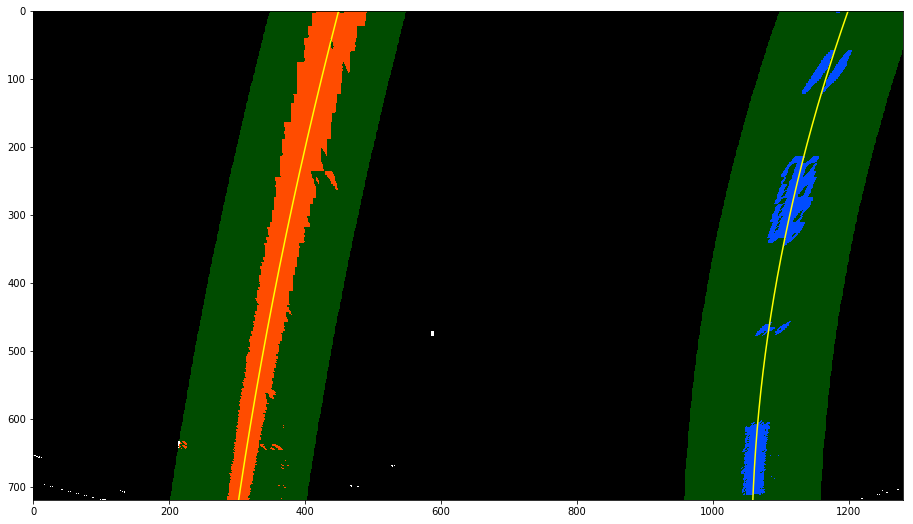

In [9]:
img = mpimg.imread('test_images/test3.jpg')
top_down, _ = get_top_down(img)
left_fit, right_fit = get_lane_line_fits_default(top_down)
out = get_lane_line_fits(top_down, plot=True, fits=(left_fit, right_fit))

## Define a function to unwarp an image

In [10]:
def get_fit_lines(image_shape, curve_fit):
    """generate points based on fit params"""
    left_fit, right_fit = curve_fit
    
    ploty = np.linspace(0, image_shape[0]-1, image_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return ploty, left_fitx, right_fitx


def unwarp_image(warped_img, Minv, img, fits, plot=False):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # get the x and y from the image space
    ploty, left_fitx, right_fitx = get_fit_lines(warped_img.shape, fits)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    if plot:
        plt.figure(figsize=(24, 9))
        plt.imshow(result)

    return result


## Define functions to compute frame info

In [11]:
# Define conversions in x and y from pixels space to meters
YM_PER_PIX = 30/720 # meters per pixel in y dimension
XM_PER_PIX = 3.7/700 # meters per pixel in x dimension
    

def compute_curvature(warped_img, curve_fit):
    # get the x and y from the image space
    ploty, left_fitx, right_fitx = get_fit_lines(warped_img.shape, curve_fit)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*YM_PER_PIX, left_fitx*XM_PER_PIX, 2)
    right_fit_cr = np.polyfit(ploty*YM_PER_PIX, right_fitx*XM_PER_PIX, 2)
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*YM_PER_PIX + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*YM_PER_PIX + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

def compute_center_offset(warped_img, curve_fit):
    # get the x and y from the image space
    ploty, left_fitx, right_fitx = get_fit_lines(warped_img.shape, curve_fit)
    
    lane_centerx = np.mean([left_fitx[0], right_fitx[0]])
    return ((warped_img.shape[1] // 2) - lane_centerx) * XM_PER_PIX


def add_stat_to_image(image, curverads, offset, frame=-1):
    # add curverature to image
    text_to_add = "Radius of Curvature: {:.2f} m".format(np.mean([*curverads]))
    cv2.putText(image, text_to_add,(50,50), cv2.FONT_HERSHEY_DUPLEX, 1,(0,255,0), 1)
    
    # add lane offset to image
    if offset > 0.01:
        text_to_add = "To the right of the center: {:.2f} m".format(offset)
    elif offset < 0.01:
        text_to_add = "To the left of the center: {:.2f} m".format(offset)
    else:
        text_to_add = "On Center!!"
    cv2.putText(image, text_to_add,(50,100), cv2.FONT_HERSHEY_DUPLEX, 1,(0,255,0), 1)
    
    # add frame info to image if available
    if frame > 0:
        text_to_add = "Frame: {}".format(frame)
        cv2.putText(image, text_to_add, (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1,(0,255,0), 1)
    return image

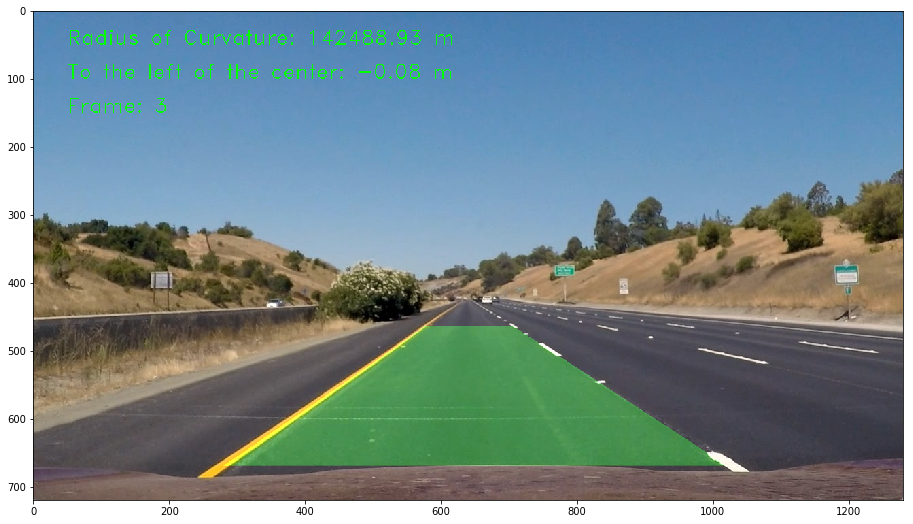

In [12]:
img = mpimg.imread('test_images/straight_lines1.jpg')
top_down_img, Minv = get_top_down(img)
fits = get_lane_line_fits_default(top_down_img)
unwarpped_image = unwarp_image(top_down_img, Minv, img, fits)   
result = add_stat_to_image(unwarpped_image, compute_curvature(top_down_img, fits), compute_center_offset(top_down_img, fits), 3)
    

plt.figure(figsize=(24, 9))
plt.imshow(result)
    

## Test the whole pipeline on video

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# define global values
frame = 0
fits = None

# define the pipeline to process one image frame
def process_image(img):
    global frame
    frame += 1

    # step 1: get the top down (warpped) view of the image 
    top_down_img, Minv = get_top_down(img)
    
    # step 2: find the lane line by finding the most fit polynomial for both left and right line
    # global fits
    # fits = get_lane_line_fits(top_down_img, fits=fits)
    fits = get_lane_line_fits_default(top_down_img)
    
    # step 3: unwarp the image into the original image
    unwarpped_image = unwarp_image(top_down_img, Minv, img, fits)
    
    # step 4: extract features from the image
    info_curvature = compute_curvature(top_down_img, fits)
    info_center_offset = compute_center_offset(top_down_img, fits)

    # step 5: return a processed image
    return add_stat_to_image(unwarpped_image, info_curvature, info_center_offset, frame)

In [20]:
# Now, run the video and the pipeline on the video
input_video_path = "project_video.mp4"
output_video_path = "output_videos/project_video.mp4"

clip1 = VideoFileClip(input_video_path)
white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video_path, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [15:05<00:00,  1.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 15min 5s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_path))

In [30]:
# Now, run the video and the pipeline on the video
input_video_path = "challenge_video.mp4"
output_video_path = "output_videos/challenge_video.mp4"

clip1 = VideoFileClip(input_video_path)
white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video_path, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [05:52<00:00,  1.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

Wall time: 5min 52s
